# [TalkingData AdTracking Fraud Detection Challenge](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/kernels?sortBy=hotness&group=everyone&pageSize=20&language=Python&competitionId=8540)

Can you detect fraudulent click traffic for mobile app ads?

## EDA

In [1]:
# ensure our graphs are displayed inline
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We'll load the entire test set into a DataFrame so we can analyze it

In [3]:
train = pd.read_csv("data/train.csv")

Now lets peak at the first few values of the data

In [4]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


We'll notice that the features `ip`, `app`, `device`, `os` and `channel` and our class variable `is_attributed` are categorical as they're encoded to anonymize and preserve privacy. Therefore we'll want to ensure we set their type to non-numerical to avoid nonense operations on the data like calculating their `mean`, `median`, ... etc.

In [5]:
categorical_columns = ["ip", "app", "device", "os", "channel", "is_attributed"]

for column in categorical_columns:
    train[column] = train[column].astype('category')

At this point we'll covert the `click_time` and `attributed_time` columns into date time fields, as they represent time series data

In [6]:
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

Now we'll get a high level look at the training data set

In [7]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,184903890.0,184903890.0,184903890.0,184903890.0,184903890.0,184903890,456846,184903890.0
unique,277396.0,706.0,3475.0,800.0,202.0,259620,182057,2.0
top,5348.0,3.0,1.0,19.0,280.0,2017-11-07 14:00:11,2017-11-08 14:16:29,0.0
freq,1238734.0,33911780.0,174330052.0,44181914.0,15065927.0,1502,14,184447044.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 16:00:00,2017-11-09 16:00:00,NaN


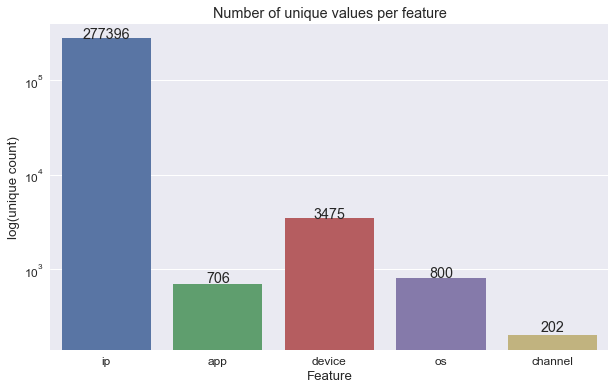

In [8]:
plt.figure(figsize=(10, 6))
cols = ["ip", "app", "device", "os", "channel"]
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel="Feature", ylabel="log(unique count)", title="Number of unique values per feature")

# Places the value just above the column
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 20,
            uniq,
            ha="center") 

From our knowledge of the competion, every row in the DataFrame that has a set value of `is_attributed` should also have a value for `attributed_time`. Lets test that belief

In [9]:
# Grabs a subset of the DataFrame and then further grabs only the rows where `is_attributed` is set, then calculating the counts
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time,is_attributed
count,456846,456846.0
unique,182057,1.0
top,2017-11-08 14:16:29,1.0
freq,14,456846.0
first,2017-11-06 16:00:47,NaN
last,2017-11-09 16:00:00,NaN


### Quick Take Aways

- The training set takes place over two days, two hours and eleven seconds
- Out of 184,903,890 rows, only 456,846 of them have an `attributed_time` values of `1.0`
  - This means only 456,846 out of 184,903,890 ad clicks resulted in a download
  - Which is about 0.0025 % of the clicks
- There is atleast one ip adress that triggers an ad click over fifty thousand times
  - Seems strange that one ip address would click that often in a span of just 4 days
  - Does that mean that ip address encoded is not device id, but network id? (explore this below)

Our data is incredilby unbalanced. We're visualizing here the small percents of ad clicks resulting in a download.

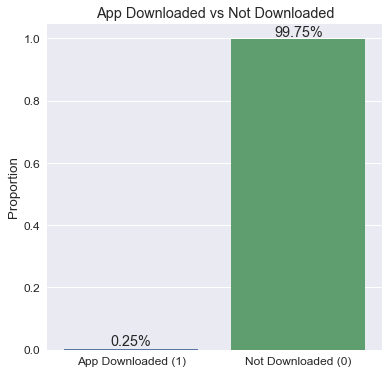

In [10]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')

for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

### Explore ip counts: _Check if multuiple ips have any downloads_

Since we don't know what `ip` is actually encoding, we're going to see if we can make any inferences based on the `value_counts()` of tha data set.

One might think that each `ip` equates to a single user, but we'll see that this is probably not the case.

In [11]:
#temporary table to see ips with their associated count frequencies
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,5348,1238734
1,5314,1171448
2,73516,770451
3,73487,763854
4,53454,498186
5,114276,427453
6,26995,401495
7,95766,378693
8,17149,310996
9,105475,302192


In [12]:
#add temporary counts of ip feature ('counts') to the train table, to see if IPs with high counts have conversions
train= train.merge(temp, on='ip', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [14]:
#check top 10 values
train[train['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
7236133,5348,3,1,41,480,2017-11-06 23:09:14,2017-11-06 23:09:15,1,1238734
54746662,5348,29,2,17,343,2017-11-07 14:19:20,2017-11-07 14:25:10,1,1238734
16559430,5348,107,1,10,171,2017-11-07 02:06:20,2017-11-07 10:09:16,1,1238734
178906362,5348,29,1,19,210,2017-11-09 14:07:48,2017-11-09 14:10:39,1,1238734
39328788,5348,43,1,16,330,2017-11-07 09:25:56,2017-11-07 09:53:30,1,1238734
39331561,5348,29,1,13,343,2017-11-07 09:25:59,2017-11-07 09:26:06,1,1238734
98050686,5348,45,1,9,411,2017-11-08 08:59:23,2017-11-08 11:27:22,1,1238734
48883725,5348,29,1,27,210,2017-11-07 12:28:20,2017-11-07 12:36:01,1,1238734
165853667,5348,20,1,12,259,2017-11-09 10:16:33,2017-11-09 11:18:16,1,1238734
172927660,5348,19,0,50,213,2017-11-09 12:23:26,2017-11-09 12:23:27,1,1238734


In [15]:
train[train['is_attributed']==1].ip.describe()

count     456846
unique    245038
top         5348
freq        2340
Name: ip, dtype: int64

## References

* https://www.kaggle.com/yuliagm/talkingdata-eda-plus-time-patterns
  - for excellent EDA